In [37]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score

In [38]:
DATASET_DIR = "BreaKHis_v1/histology_slides/breast"
MAGNIFICATIONS = ["40X", "100X", "200X", "400X"]

In [39]:
# Dataset generators
IMG_SIZE = (128, 128)  # Change to (224, 224) for ResNet50
BATCH_SIZE = 32

In [61]:
def load_dataset_structure(dataset_dir):
    data = []
    for root, dirs, files in os.walk(dataset_dir):
        for file in files:
            if file.endswith(('.png')):
                class_label = os.path.basename(root)  
                file_path = os.path.join(root, file)
                data.append({'file_path': file_path, 'class': class_label})
    return pd.DataFrame(data)

In [42]:
def visualize_class_distribution(dataset_df):
    
    class_counts = dataset_df['class'].value_counts()
    plt.figure(figsize=(10, 6))
    class_counts.plot(kind='bar', color='skyblue')
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()


In [43]:
def preprocess_and_split(dataset_df, test_size=0.15, val_size=0.15):
    
    train_val_df, test_df = train_test_split(dataset_df, test_size=test_size, stratify=dataset_df['class'], random_state=42)
    train_df, val_df = train_test_split(train_val_df, test_size=val_size / (1 - test_size), stratify=train_val_df['class'], random_state=42)
    return train_df, val_df, test_df

In [44]:
def create_generators(train_df, val_df, test_df, target_size=(224, 224), batch_size=32): # for training, validation, and testing.
    
    datagen = ImageDataGenerator(rescale=1.0 / 255)

    train_gen = datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='image_path',  # Changed from file_path to image_path
        y_col='class',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    val_gen = datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='image_path',  # Changed from file_path to image_path
        y_col='class',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_gen = datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='image_path',  # Changed from file_path to image_path
        y_col='class',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_gen, val_gen, test_gen


In [62]:
# Load the dataset
print("Loading dataset structure...")
dataset_df = load_dataset_structure(DATASET_DIR)
if len(dataset_df) == 0:
    print("No images were found in the dataset directory. Please check the directory path.")
else:
    print(f"Loaded {len(dataset_df)} images from the dataset.")


Loading dataset structure...
Loaded 7909 images from the dataset.


Visualizing class distribution...


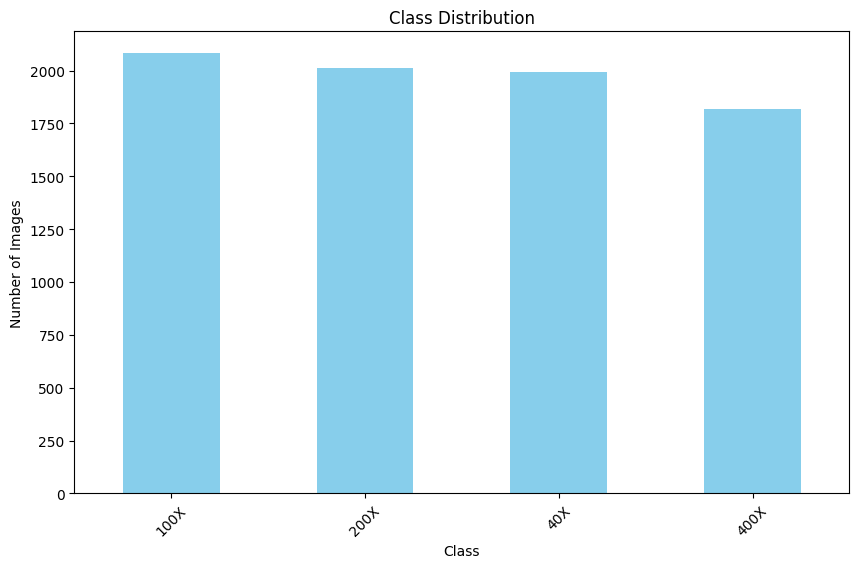

In [46]:
# Visualize class distribution
print("Visualizing class distribution...")
visualize_class_distribution(dataset_df)

In [47]:
# Preprocess and split the dataset
print("Splitting dataset into training, validation, and testing sets...")
train_df, val_df, test_df = preprocess_and_split(dataset_df)
print(f"Training set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Testing set: {len(test_df)} images")

Splitting dataset into training, validation, and testing sets...
Training set: 5535 images
Validation set: 1187 images
Testing set: 1187 images


In [48]:
print(f"Columns in train_df: {train_df.columns}")
print(f"Columns in val_df: {val_df.columns}")
print(f"Columns in test_df: {test_df.columns}")

Columns in train_df: Index(['file_path', 'class'], dtype='object')
Columns in val_df: Index(['file_path', 'class'], dtype='object')
Columns in test_df: Index(['file_path', 'class'], dtype='object')


In [49]:
# Rename image_path to file_path
dataset_df.rename(columns={'image_path': 'file_path'}, inplace=True)
train_df.rename(columns={'image_path': 'file_path'}, inplace=True)
val_df.rename(columns={'image_path': 'file_path'}, inplace=True)
test_df.rename(columns={'image_path': 'file_path'}, inplace=True)

# Verify the rename worked
print(f"Columns in train_df: {train_df.columns}")
print(f"Columns in val_df: {val_df.columns}")
print(f"Columns in test_df: {test_df.columns}")


Columns in train_df: Index(['file_path', 'class'], dtype='object')
Columns in val_df: Index(['file_path', 'class'], dtype='object')
Columns in test_df: Index(['file_path', 'class'], dtype='object')


In [50]:
def create_generators_from_df(train_df, val_df, test_df):
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1.0 / 255.0,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    val_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255.0)

    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='file_path',  
        y_col='class',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )

    val_gen = val_test_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='file_path',  
        y_col='class',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )

    test_gen = val_test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='file_path', 
        y_col='class',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    return train_gen, val_gen, test_gen


In [51]:
# TODO cerify generators after renaming
print("Creating data generators...")
try:
    train_gen, val_gen, test_gen = create_generators_from_df(train_df, val_df, test_df)
    print("Data generators created successfully.")
except Exception as e:
    print(f"Error in creating data generators: {e}")

# Verify generator details
print(f"Number of training samples: {train_gen.samples}")
print(f"Number of validation samples: {val_gen.samples}")
print(f"Number of test samples: {test_gen.samples}")


Creating data generators...
Found 5535 validated image filenames belonging to 4 classes.
Found 1187 validated image filenames belonging to 4 classes.
Found 1187 validated image filenames belonging to 4 classes.
Data generators created successfully.
Number of training samples: 5535
Number of validation samples: 1187
Number of test samples: 1187


In [52]:
print("Columns in train_df:", train_df.columns)
print("Columns in val_df:", val_df.columns)
print("Columns in test_df:", test_df.columns)

Columns in train_df: Index(['file_path', 'class'], dtype='object')
Columns in val_df: Index(['file_path', 'class'], dtype='object')
Columns in test_df: Index(['file_path', 'class'], dtype='object')


In [53]:
print(train_df.head())
print(val_df.head())
print(test_df.head())

                                              file_path class
133   BreaKHis_v1/histology_slides/breast\benign\SOB...  100X
6732  BreaKHis_v1/histology_slides/breast\malignant\...  100X
5938  BreaKHis_v1/histology_slides/breast\malignant\...  100X
3993  BreaKHis_v1/histology_slides/breast\malignant\...  200X
254   BreaKHis_v1/histology_slides/breast\benign\SOB...  100X
                                              file_path class
7206  BreaKHis_v1/histology_slides/breast\malignant\...  100X
3568  BreaKHis_v1/histology_slides/breast\malignant\...   40X
6815  BreaKHis_v1/histology_slides/breast\malignant\...   40X
5355  BreaKHis_v1/histology_slides/breast\malignant\...  400X
1809  BreaKHis_v1/histology_slides/breast\benign\SOB...  400X
                                              file_path class
5759  BreaKHis_v1/histology_slides/breast\malignant\...  400X
6501  BreaKHis_v1/histology_slides/breast\malignant\...  200X
3848  BreaKHis_v1/histology_slides/breast\malignant\...   40X
2131  Br

In [54]:
train_gen, val_gen, test_gen = create_generators_from_df(train_df, val_df, test_df)

Found 5535 validated image filenames belonging to 4 classes.
Found 1187 validated image filenames belonging to 4 classes.
Found 1187 validated image filenames belonging to 4 classes.


In [55]:
def build_cnn(input_shape, num_classes):

    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [56]:
# Compile and Train CNN
cnn_model = build_cnn((IMG_SIZE[0], IMG_SIZE[1], 3), len(train_gen.class_indices))
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

print("Training CNN from scratch...")
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_cnn = cnn_model.fit(train_gen, validation_data=val_gen, epochs=100, verbose=1, callbacks=[early_stopping])

# Evaluate CNN
print("Evaluating CNN...")
cnn_loss, cnn_acc = cnn_model.evaluate(test_gen, verbose=1)
print(f"CNN Test Accuracy: {cnn_acc:.4f}")

Training CNN from scratch...


c:\Users\barga\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\barga\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 104s 596ms/step - accuracy: 0.2657 - loss: 1.4313 - val_accuracy: 0.3665 - val_loss: 1.3618
Epoch 2/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 91s 528ms/step - accuracy: 0.2888 - loss: 1.3637 - val_accuracy: 0.2864 - val_loss: 1.3757
Epoch 3/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 83s 480ms/step - accuracy: 0.3147 - loss: 1.3523 - val_accuracy: 0.2612 - val_loss: 1.3821
Epoch 4/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 144s 833ms/step - accuracy: 0.2993 - loss: 1.3563 - val_accuracy: 0.4549 - val_loss: 1.1986
Epoch 5/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 100s 578ms/step - accuracy: 0.3986 - loss: 1.2365 - val_accuracy: 0.3328 - val_loss: 1.2836
Epoch 6/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 78s 450ms/step - accuracy: 0.4769 - loss: 1.0936 - val_accuracy: 0.4819 - val_loss: 1.0038
Epoch 7/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 78s 449ms/step - accuracy: 0.5773 - loss: 0.9416 - val_accuracy: 0.6403 - val_loss: 0.8340
Epoch 8/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 78s 450ms/step - accuracy: 0.619

In [57]:
def build_resnet50(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base model layers
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [58]:

# Compile and Train ResNet50
resnet50_model = build_resnet50((IMG_SIZE[0], IMG_SIZE[1], 3), len(train_gen.class_indices))
resnet50_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

print("Training ResNet50 model...")
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_resnet = resnet50_model.fit(train_gen, validation_data=val_gen, epochs=100, verbose=1, callbacks=[early_stopping])

# Fine-tune ResNet50
print("Fine-tuning ResNet50...")
resnet50_model.layers[0].trainable = True  # Unfreeze base model
resnet50_model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
history_resnet_ft = resnet50_model.fit(train_gen, validation_data=val_gen, epochs=5, verbose=1)

# Evaluate ResNet50
print("Evaluating ResNet50...")
resnet_loss, resnet_acc = resnet50_model.evaluate(test_gen, verbose=1)
print(f"ResNet50 Test Accuracy: {resnet_acc:.4f}")

Training ResNet50 model...
Epoch 1/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 119s 668ms/step - accuracy: 0.2532 - loss: 1.5096 - val_accuracy: 0.3496 - val_loss: 1.3733
Epoch 2/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 114s 657ms/step - accuracy: 0.2731 - loss: 1.4051 - val_accuracy: 0.3471 - val_loss: 1.3597
Epoch 3/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 114s 657ms/step - accuracy: 0.2878 - loss: 1.3842 - val_accuracy: 0.3850 - val_loss: 1.3528
Epoch 4/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 114s 657ms/step - accuracy: 0.3273 - loss: 1.3590 - val_accuracy: 0.3732 - val_loss: 1.3375
Epoch 5/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 113s 655ms/step - accuracy: 0.3401 - loss: 1.3466 - val_accuracy: 0.4271 - val_loss: 1.3274
Epoch 6/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 115s 662ms/step - accuracy: 0.3682 - loss: 1.3321 - val_accuracy: 0.4221 - val_loss: 1.3158
Epoch 7/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 113s 655ms/step - accuracy: 0.3913 - loss: 1.3155 - val_accuracy: 0.3656 - val_loss: 1.3062
Epoch 8/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1

In [59]:
def plot_history(history, title):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Evaluating ResNet50...
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 489ms/step - accuracy: 0.2900 - loss: 6.7823
ResNet50 Test Accuracy: 0.2856
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 250ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 510ms/step
CNN Classification Report:
              precision    recall  f1-score   support

        100X       0.70      0.66      0.68       312
        200X       0.84      0.74      0.78       302
        400X       0.96      0.86      0.91       273
         40X       0.73      0.94      0.82       300

    accuracy                           0.80      1187
   macro avg       0.81      0.80      0.80      1187
weighted avg       0.80      0.80      0.79      1187

ResNet50 Classification Report:
              precision    recall  f1-score   support

        100X       0.22      0.31      0.26       312
        200X       0.14      0.07      0.10       302
        400X       0.61      0.38      0.47       273
         40X       0.27      0.39      0.32       300

    accuracy        

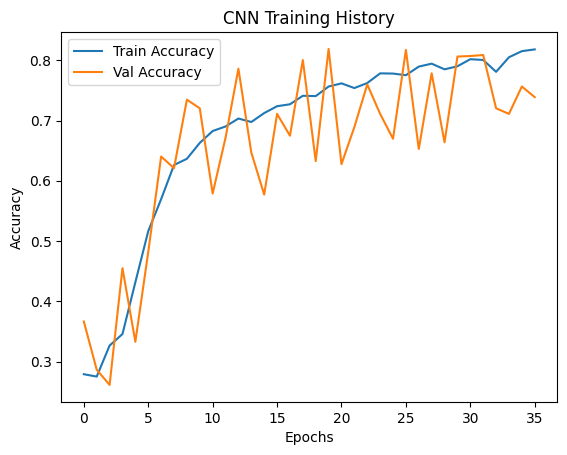

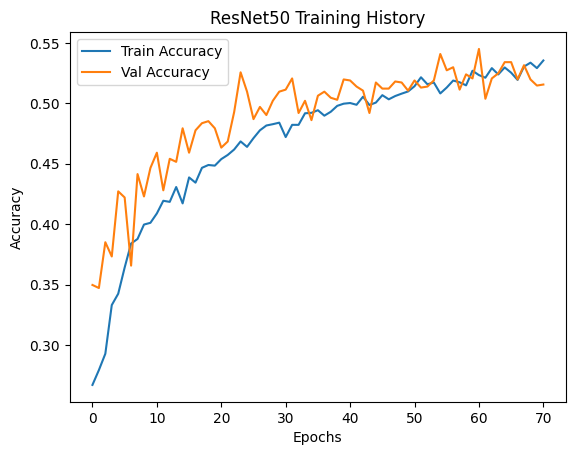

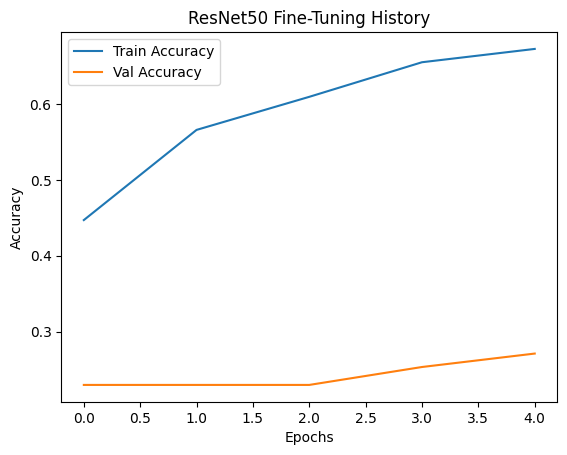

In [60]:
# Generate classification report
test_gen.reset()
y_true = test_gen.classes
y_pred_cnn = cnn_model.predict(test_gen)
y_pred_resnet = resnet50_model.predict(test_gen)

print("CNN Classification Report:")
print(classification_report(y_true, y_pred_cnn.argmax(axis=1), target_names=list(test_gen.class_indices.keys())))

print("ResNet50 Classification Report:")
print(classification_report(y_true, y_pred_resnet.argmax(axis=1), target_names=list(test_gen.class_indices.keys())))

# Compute AUC-ROC
print("AUC-ROC Scores:")
cnn_auc = roc_auc_score(y_true, y_pred_cnn, multi_class='ovr')
resnet_auc = roc_auc_score(y_true, y_pred_resnet, multi_class='ovr')
print(f"CNN AUC-ROC: {cnn_auc:.4f}")
print(f"ResNet50 AUC-ROC: {resnet_auc:.4f}")

plot_history(history_cnn, "CNN Training History")
plot_history(history_resnet, "ResNet50 Training History")
plot_history(history_resnet_ft, "ResNet50 Fine-Tuning History")
